This notebook is for further investigation of the Potts model in predicting protein fitness with MSA. 

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from model import CouplingsModel
import tools
import scipy
from pathlib import Path
from collections import OrderedDict
# biopython SeqIO
from Bio import SeqIO
from sklearn.metrics import roc_auc_score
import scipy

In [52]:
ALPHABET_PROTEIN = '-ACDEFGHIKLMNPQRSTVWY'
def check_sequence(s, alphabet=ALPHABET_PROTEIN):
    for aa in s:
        if aa not in ALPHABET_PROTEIN:
            return False
    return True

In [53]:
NAME = 'PABP_YEAST'

### training code for model, uncomment the following line: 
#!plmc/bin/plmc -o PABP_YEAST/model/{NAME}.model_params -c PABP_YEAST/model/{NAME}.txt -f PABP_YEAST -le 16.2 -lh 0.01 -m 200 -t 0.2 -g PABP_YEAST/data/{NAME}.a2m
c = CouplingsModel(f"PABP_YEAST/model/{NAME}.model_params")

In [19]:
# load parameters from file to create a pairwise model
c = CouplingsModel(f"PABP_YEAST/model/{NAME}.model_params")
# read the experimental mutational scanning dataset for PABP by Melamed et al., RNA, 2013
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)
# wt = {"mutant": "wild", "linear": 0, "log": 0}
# data = data.append(wt, ignore_index=True)

In [54]:

# predict mutations using our model
data_pred = tools.predict_mutation_table(
    c, data, "effect_prediction_epistatic"
)

# can also add predictions by the corresponding independent model
c0 = c.to_independent_model()

data_pred = tools.predict_mutation_table(
    c0, data_pred, "effect_prediction_independent"
)
print(data_pred.head())
pred = data_pred['effect_prediction_epistatic']
pred_ind = data_pred['effect_prediction_independent']
label = data_pred['linear']
print('Evmutation spearman: ', scipy.stats.spearmanr(pred, label))
print('Independent control spearman: ', scipy.stats.spearmanr(pred_ind, label))

  mutant    linear       log  effect_prediction_epistatic  \
0  G126A  0.711743 -0.490571                    -2.597435   
1  G126C  0.449027 -1.155127                    -5.653770   
2  G126E  0.588928 -0.763836                    -6.589126   
3  G126D  0.229853 -2.121218                    -7.249220   
4  G126N  0.679435 -0.557593                    -5.799652   

   effect_prediction_independent  
0                       0.406487  
1                      -0.027602  
2                      -1.827570  
3                      -1.180076  
4                       0.387440  
Evmutation spearman:  SpearmanrResult(correlation=0.59280030296668, pvalue=1.2266190417209348e-113)
Independent control spearman:  SpearmanrResult(correlation=0.4236780791119215, pvalue=6.077688379018816e-53)


In [55]:
yeast_seq_str = []
fasta_sequences = SeqIO.parse(open("PABP_YEAST/data/PABP_YEAST.a2m"),'fasta')
for fasta in fasta_sequences:
    yeast_seq_str.append(str(fasta.seq))

In [56]:
pos_upper = [x for x in range(len(yeast_seq_str[0])) if not yeast_seq_str[0][x].islower()]
processed_yeast = np.asarray([np.asarray(list(s))[pos_upper] for s in yeast_seq_str])
processed_yeast = np.asarray([s for s in processed_yeast if check_sequence(s)])
wildtype = yeast_seq_str[0]

In [57]:
print(len(yeast_seq_str))
print(processed_yeast.shape)

152041
(151528, 82)


In [8]:
mutant, label = data['mutant'].to_numpy(), data['linear'].to_numpy()
mutant_data = []
for m in mutant:
    if m == 'wild':
        mutant_data.append(np.asarray(list(wildtype))[pos_upper])
        continue
    original_aa, loc, mutant_aa = m[0], int(m[1:4])-115, m[4]
    assert wildtype[loc] == original_aa
    mut_seq = np.asarray(list(wildtype[:loc]+mutant_aa+wildtype[loc+1:]))
    mutant_data.append(mut_seq[pos_upper])
mutant_data = np.asarray(mutant_data)
mutant_data

array([['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ...,
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R'],
       ['K', 'G', 'S', ..., 'L', 'S', 'R']], dtype='<U1')

In [84]:
mutant_energies = c.hamiltonians(mutant_data.tolist())

# c.delta_hamiltonian

In [80]:
# modify energy computation to enable computing sequences with gap characters
def mod_convert_sequences(sequences):
    """
    Converts sequences in string format into internal symbol representation
    according to alphabet of model

    Parameters
    ----------
    sequences : list of str
        List of sequences (must have same length and correspond to
        model states)

    Returns
    -------
    np.array
        Matrix of size len(sequences) x L of sequences converted to
        integer symbols
    """
    seq_lens = list(set(map(len, sequences)))
    if len(seq_lens) != 1:
        raise ValueError("Input sequences have different lengths: " + str(seq_lens))

    L_seq = seq_lens[0]

    S = np.empty((len(sequences), L_seq), dtype=np.int)

    try:
        for i, s in enumerate(sequences):
            conv = []
            for x in s:
                if x == '-':
                    conv.append(-1)
                else:
                    conv.append(c.alphabet_map[x])
            S[i] = conv
    except KeyError:
        raise ValueError("Invalid symbol in sequence {}: {}".format(i, x))
    return S
    
def mod_hamiltonians(sequences, J_ij, h_i):
    """
    Calculates the Hamiltonian of the global probability distribution P(A_1, ..., A_L)
    for a given sequence A_1,...,A_L from J_ij and h_i parameters

    Parameters
    ----------
    sequences : np.array
        Sequence matrix for which Hamiltonians will be computed
    J_ij: np.array
        L x L x num_symbols x num_symbols J_ij pair coupling parameter matrix
    h_i: np.array
        L x num_symbols h_i fields parameter matrix

    Returns
    -------
    np.array
        Float matrix of size len(sequences) x 3, where each row corresponds to the
        1) total Hamiltonian of sequence and the 2) J_ij and 3) h_i sub-sums
    """
    # iterate over sequences
    N, L = sequences.shape
    H = np.zeros((N, 3))
    for s in range(N):
        A = sequences[s]
        hi_sum = 0.0
        Jij_sum = 0.0
        for i in range(L):
            if A[i] != -1:
                hi_sum += h_i[i, A[i]]
                for j in range(i + 1, L):
                    if A[j] != -1:
                        Jij_sum += J_ij[i, j, A[i], A[j]]

        H[s] = [Jij_sum + hi_sum, Jij_sum, hi_sum]

    return H

In [81]:
S = mod_convert_sequences(processed_yeast.tolist())

/tmp/ipykernel_3373741/1363331714.py:25: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  S = np.empty((len(sequences), L_seq), dtype=np.int)


In [83]:
msa_energies = mod_hamiltonians(S, c.J_ij, c.h_i)

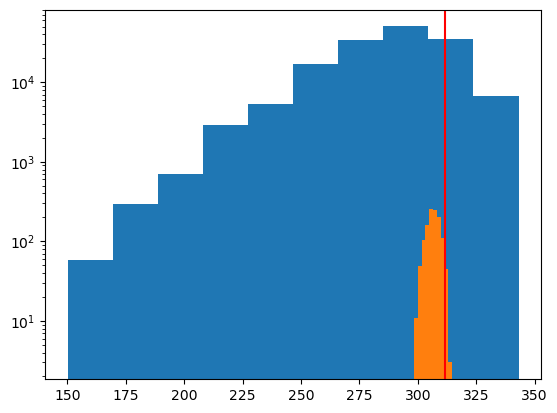

In [88]:
plt.hist(msa_energies[:, 0])
plt.hist(mutant_energies[:, 0])
plt.axvline(x=c.hamiltonians([c.seq()])[0][0], color='red')
plt.yscale('log')
plt.show()

In [47]:
energies = c.hamiltonians(processed_yeast)[:, 0]
wt_energy = energies[0]
# c.hamiltonians([s])
data = pd.read_csv(
    "PABP_YEAST/data/PABP_YEAST_Fields2013-singles.csv", sep=";", comment="#"
)


# predict mutations using our model
data_pred = tools.predict_mutation_table(
    c, data, "effect_prediction_epistatic"
)
evm_pred = data_pred['effect_prediction_epistatic'].to_numpy()
evm_pred_pos = evm_pred[np.where(label>=1)]+wt_energy
evm_pred_neg = evm_pred[np.where(label<1)]+wt_energy

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function getitem>) found for signature:
 
 >>> getitem(array(float32, 2d, C), Tuple(int64, [unichr x 1]))
 
There are 22 candidate implementations:
   - Of which 20 did not match due to:
   Overload of function 'getitem': File: <numerous>: Line N/A.
     With argument(s): '(array(float32, 2d, C), Tuple(int64, [unichr x 1]))':
    No match.
   - Of which 2 did not match due to:
   Overload in function 'GetItemBuffer.generic': File: numba/core/typing/arraydecl.py: Line 166.
     With argument(s): '(array(float32, 2d, C), Tuple(int64, [unichr x 1]))':
    Rejected as the implementation raised a specific error:
      NumbaTypeError: unsupported array index type [unichr x 1] in Tuple(int64, [unichr x 1])
  raised from /data/anaconda3/envs/dev_arthur/lib/python3.9/site-packages/numba/core/typing/arraydecl.py:72

During: typing of intrinsic-call at /home/arthur/dev/msa_classify/model.py (56)

File "model.py", line 56:
def _hamiltonians(sequences, J_ij, h_i):
    <source elided>
        for i in range(L):
            hi_sum += h_i[i, A[i]]
            ^
